In [1]:
import os
from modulus.sym.hydra import to_absolute_path
from csv_rw import csv_to_dict
import csv
import numpy as np
import glob
from multiprocessing import Process
from fwdFacingStep import ffs, param_ranges, Re, Ho, Lo


In [2]:
def readFile(file_path):
    with open(file_path, "r") as datafile:
        data = []
        reader = csv.reader(datafile, delimiter=",")
        for row in reader:
            columns = [row[1]]
            data.append(columns)
        last_row = float(data[-1][0])
        return last_row

In [19]:
# Read and Compare Delta Cp

from os import listdir
from modulus.sym.domain.validator import Validator
from statistics import mean 


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda1@500k"]

dirSkip = [".hydra", "init", "vtp", "data1800PlusPhysicsLambda1@100k2pO@300k", "data1800PlusPhysicsLambda1@100k2pO@500k", "data1800PlusPhysicsLambda1@300k2pO@500k"]

diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDSP= {}
        diffUSP= {}
        diffDCp= {}

        for i, row in enumerate(reader):
            if i == 0:
                # add columns for difference modulus vs ansys
                row.insert(5, "Diff Delta Cp [%]")
                # row.insert(7, "Diff Delta Cptot [%]")
                writer.writerow(row)
            else:
                for model in models:
                        if model in dirSkip:
                                # print("skipping ", model)
                                continue
                        
                        monitorFilePath = os.path.join(outputsPath, model, "monitors")
                        # read pressure monitors
                        filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        DSP=readFile(monitorFile[0])
                        # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # DSPtot=readFile(monitorFile[0])
                        filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        USP=readFile(monitorFile[0])
                        # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # USPtot=readFile(monitorFile[0])
                        
                        # calculate modulus pressure drop and difference modulus vs ansys
                        deltaCp=2*(USP-DSP)
                        
                        trueDSP = float(row[5])
                        trueUSP = float(row[6])
                        trueDeltaCp = float(row[4])
                        
                        if row[0] not in diffSumSkip:
                            if model not in diffDSP.keys():
                                diffDSP[model] = [abs(100*(DSP - trueDSP)/trueDSP)]
                            else:
                                diffDSP[model].append(abs(100*(DSP - trueDSP)/trueDSP))
                                
                            if model not in diffUSP.keys():
                                diffUSP[model] = [abs(100*(USP - trueUSP)/trueUSP)]
                            else:
                                diffUSP[model].append(abs(100*(USP - trueUSP)/trueUSP))
                                
                            if model not in diffDCp.keys():
                                diffDCp[model] = [abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp)]
                            else:
                                diffDCp[model].append(abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp))
                                
                        
                        
                        # add modulus results to table
                        # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                        # writer.writerow(modRow)
            # Add deviation sum
        firstRow = ["Model", "DSP Mean", "DSP Min", "DSP Max", "USP Mean", "USP Min", "USP Max", "DCp Mean", "DCp Min", "DCp Max"]
        
        writer.writerow(firstRow)
        
        # print(diffDSP)
        # print(diffUSP)
        # print(diffDCp)
        
        for model in models:
            if model in dirSkip:
                # print("skipping ", model)
                continue
            
            maxDSP = max(diffDSP[model])
            maxUSP = max(diffUSP[model])
            maxDCp = max(diffDCp[model])

            minDSP = min(diffDSP[model])
            minUSP = min(diffUSP[model])
            minDCp = min(diffDCp[model])
            
            meanDSP = mean(diffDSP[model])
            meanUSP = mean(diffUSP[model])
            meanDCp = mean(diffDCp[model])
                
            row = [model, meanDSP, minDSP, maxDSP, meanUSP, minUSP, maxUSP, meanDCp, minDCp, maxDCp]
            writer.writerow(row)
            
            latexStr = model
                
            for value in row[1:]:
                # print(value)
                valueF = round(float(value), 4)
                latexStr += " & " + "%.4f" % valueF
            latexStr += " \\\\"
            print(latexStr)                    
                                


data1800PlusPhysicsLambda01@100k & 3.3575 & 0.0480 & 7.7932 & 2.8056 & 0.2033 & 7.4185 & 4.0000 & 0.0341 & 8.3651 \\
data1800PlusPhysicsLambda01@300k & 3.0802 & 0.5726 & 6.3171 & 1.4643 & 0.2184 & 3.6186 & 1.0128 & 0.0636 & 2.2134 \\
data1800PlusPhysicsLambda01@500k & 3.1638 & 0.3520 & 6.0956 & 1.3168 & 0.1551 & 3.0894 & 0.8495 & 0.0760 & 2.1968 \\
data1800PlusPhysicsLambda1@100k & 3.2938 & 0.1523 & 11.7820 & 2.1482 & 0.0405 & 7.6961 & 1.9453 & 0.0726 & 5.5697 \\
data1800PlusPhysicsLambda1@300k & 2.2611 & 0.0627 & 7.9794 & 1.4229 & 0.0504 & 5.3362 & 1.4543 & 0.0748 & 4.8295 \\
data1800PlusPhysicsLambda1@500k & 2.1155 & 0.1263 & 7.3544 & 1.3318 & 0.0091 & 4.8957 & 1.3812 & 0.0258 & 4.4956 \\
dataOnly1800@100k & 11.4502 & 2.1248 & 29.4528 & 6.3774 & 0.1149 & 18.8695 & 5.7416 & 0.0363 & 18.0339 \\
dataOnly1800@300k & 10.8237 & 2.0314 & 28.1015 & 5.8851 & 0.2802 & 17.2980 & 5.3193 & 0.3236 & 17.0566 \\
dataOnly1800@500k & 10.7369 & 2.0435 & 27.9233 & 5.8340 & 0.2712 & 16.9747 & 5.2383 & 0.

In [5]:
# Read and Compare Delta Cp OLD

from os import listdir
from modulus.sym.domain.validator import Validator


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

# models = ["old_dataPlusPhysics3600@300k", "data3600PlusPhysicsLambda05@300k", "data3600PlusPhysicsLambda1@300k", "old_physicsOnly@500k", "physicsOnly@500k"]

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k", "data1800PlusPhysicsLambda1@500k"]


diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDict= {}
        for model in models:
                diffDict[model] = 0
                # print(type(diffDict[model]))
        for i, row in enumerate(reader):
                if i == 0:
                        # add columns for difference modulus vs ansys
                        row.insert(5, "Diff Delta Cp [%]")
                        # row.insert(7, "Diff Delta Cptot [%]")
                        writer.writerow(row)
                else:
                        # add ansys results to table
                        row.insert(5, "-")
                        # row.insert(7, "-")
                        writer.writerow(row)
                        for model in models:
                                print(model)
                                if model in dirSkip:
                                        print("skipping ", model)
                                        continue
                                
                                monitorFilePath = os.path.join(outputsPath, model, "monitors")
                                # read pressure monitors
                                filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                DSP=readFile(monitorFile[0])
                                # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # DSPtot=readFile(monitorFile[0])
                                filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                USP=readFile(monitorFile[0])
                                # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # USPtot=readFile(monitorFile[0])
                                
                                # calculate modulus pressure drop and difference modulus vs ansys
                                deltaCp=2*(USP-DSP)
                                # deltaCptot=2*(USPtot-DSPtot)
                                deltaCpTrue = float(row[4])
                                diffDeltaCp=100*(deltaCp-deltaCpTrue)/deltaCpTrue
                                # diffDeltaCptot=100*(deltaCptot-float(row[6]))/float(row[6])
                                
                                if row[0] not in diffSumSkip:
                                        diffDict[model] += abs(diffDeltaCp)
                                
                                # add modulus results to table
                                modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [DSP] + [USP]
                                # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                                writer.writerow(modRow)
        # Add deviation sum
        for model in models:
                deviationRow = ["Sum " + model] + ["-"] + ["-"] + ["-"] + ["-"] + [diffDict[model]] + ["-"] + ["-"]
                writer.writerow(deviationRow)
                
                                
                                


physicsOnly@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda1@500k
physicsOnly@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda1@500k
physicsOnly@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda1@500k
physicsOnly@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda1@500k
physicsOnly@500k
ns DP 154
data1800PlusPhysicsLambda01@500k
ns DP 154
data1800PlusPhysicsLambda1@500k
ns DP 154
physicsOnly@500k
ns DP 155
data1800PlusPhysicsLambda01@500k
ns DP 155
data1800PlusPhysicsLambda1@500k
ns DP 155
physicsOnly@500k
ns DP 156
data1800PlusPhysicsLambda01@500k
ns DP 156
data1800PlusPhysicsLambda1@500k
ns DP 156
physicsOnly@500k
ns DP 157
data1800PlusPhysicsLambda01@500k
ns DP 157
data1800PlusPhysicsLambda1@500k
ns DP 157
physicsOnly@500k
ns DP 158
data1800PlusPhysicsLambda01@500k
ns DP 158
data1800PlusPhysicsLambda1@500k
ns DP 158
physicsOnly@500k
ns DP 159
data1800PlusPhysicsLambda01@500k
ns DP 159
data1800PlusPhysicsLambda1@500k
ns DP 159


In [1]:
# Read Optimization Results

import csv
from os import listdir
import numpy as np

resultsFilePath="./resultsOpt.csv"

dirSkip = [".hydra", "init"]

optResultsPath = "./optimizationResults/"

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@300k"]
models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k"]
# models = listdir(optResultsPath)
# models.sort()

with open(resultsFilePath, "w") as resultsFile:
    writer = csv.writer(resultsFile, delimiter=",")
    
    firstRow = ["model", "Re", "Lo", "Ho", "delta Cp", "delta Cp Ref"]
    writer.writerow(firstRow)


    for model in models:
        if model in dirSkip:
            print("skipping ", model)
            continue
            
        optPath = optResultsPath + model
        for reNr in range (100, 1100, 100):

            F = np.load(optPath + "/optResultsF" + str(reNr) + ".npy")
            X = np.load(optPath + "/optResultsX" + str(reNr) + ".npy")
            popF = np.load(optPath + "/popF" + str(reNr) + ".npy")
            popX = np.load(optPath + "/popX" + str(reNr) + ".npy") 
            # print("Re " + str(re) + " F: ", F)
            # print("Re " + str(reNr) + ": Lo = " + str(X[0]), " Ho = " + str(X[1]))
            
            row = [model]
            row += [reNr, X[0], X[1], F[0]]
            
            if reNr == 100:
                latexStr = model + " & " + str(reNr)
            else:
                latexStr = " " + " & " + str(reNr)
            
            for value in row[2:]:
                # print(value)
                valueF = round(float(value), 4)
                latexStr += " & " + "%.4f" % valueF
            latexStr += " & - "
            latexStr += " \\\\"
            

            
            writer.writerow(row)
            print(latexStr)
        print("\\hline")


physicsOnly@500k & 100 & 0.2117 & 0.1000 & 20.1844 & -  \\
  & 200 & 0.2000 & 0.1000 & 14.6800 & -  \\
  & 300 & 0.2000 & 0.3328 & 12.4632 & -  \\
  & 400 & 0.2000 & 0.3361 & 11.2295 & -  \\
  & 500 & 0.2000 & 0.3370 & 10.4113 & -  \\
  & 600 & 0.2000 & 0.3390 & 9.8743 & -  \\
  & 700 & 0.2000 & 0.3407 & 9.4838 & -  \\
  & 800 & 0.2000 & 0.3426 & 9.1810 & -  \\
  & 900 & 0.2000 & 0.3433 & 8.9780 & -  \\
  & 1000 & 0.2000 & 0.3436 & 8.9407 & -  \\
\hline


FileNotFoundError: [Errno 2] No such file or directory: './optimizationResults/data1800PlusPhysicsLambda01@500k/optResultsF100.npy'

FileNotFoundError: [Errno 2] No such file or directory: './AnsysResponseRe500Ho0.2.csv'

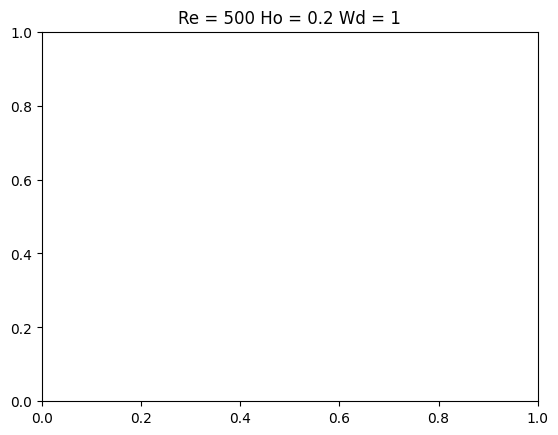

In [22]:
# Read Response Results

import csv
from os import listdir
import numpy as np
import matplotlib.pyplot as plt


# resultsFilePath="./resultsOpt.csv"

shortNameDict = {
    "data1800PlusPhysicsLambda1": "D+P",
    # "data1800PlusPhysicsLambda1": "D+P_L1",
    "data1800PlusPhysicsLambda01": "D+P",
    # "data1800PlusPhysicsLambda01": "D+P_L0.1",
    "dataOnly1800": "D",
    "physicsOnly": "P",
    "pressureDataPlusPhysicsLambda1": "PD+P",
    "2pO": "toP"
}

dirSkip = ["dataOnly1800@500k", "pressureDataPlusPhysicsLambda1@500k", ""]

resultsPath = "./responseResults/"

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@300k"]
# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k"]
models = listdir(resultsPath)
models.sort()

for L in ["1", "0.1"]:
    for reNr in [500, 800]:
        # for HoV in [0.35, 0.4, 0.45]:
        for HoV in [0.2, 0.3, 0.4]:
            title = "Re = " + str(reNr) + " Ho = " + str(HoV) + " Wd = " + L
            plt.figure()
            plt.title(title)
            
            #plot ansys response for comparison
            # ansysFilePath = "./AnsysResponseRe" + str(reNr) + "Ho" + str(HoV) + ".csv"
            # with open(ansysFilePath, "r") as ansysFile:
            #     x_vals_ans = []
            #     y_vals_ans = []
            #     reader = csv.reader(ansysFile, delimiter=",")
            #     for i in range(8):
            #             reader.__next__()
            #     for row in reader:
            #         x_vals_ans.append(float(row[0]))
            #         y_vals_ans.append(float(row[1]))
            
            # plt.plot(x_vals_ans, y_vals_ans, label="ansys")

            #plot response for modulus models
            for model in models:
                if model in dirSkip or ("Lambda" + L.replace(".", "") not in model and "data" in model):
                    print("skipping ", model)
                    continue
                        
                path = resultsPath + model

                # designs = np.load(path + "/designsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
                # results = np.load(path + "/resultsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
                
                designs = np.load(path + "/designsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")
                results = np.load(path + "/resultsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")

                # x_vals = [val[0] for val in designs]
                x_vals = [val[1] for val in designs]
                
                modelStrSplit = model.split("@")
                
                if len(modelStrSplit) == 3:
                    label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[1].split("k")[0] + "k_" + shortNameDict[modelStrSplit[1].split("k")[-1]]
                elif len(modelStrSplit) == 2:
                    label = shortNameDict[modelStrSplit[0]]
                
                plt.plot(x_vals, results, label=label)
                
            plt.legend()
            plt.xlabel("Lo")
            plt.ylabel("delta Cp")
            plt.savefig(title + ".png", dpi = 600)

('hej', 2)

In [25]:
Lo = np.arange(0.2, 1.05, 0.05)
Ho = np.full_like(Lo, 0.4)

In [28]:
designs = [
    [val[0], val[1]] for val in zip(Lo, Ho)
    ]
print(designs)

[[0.2, 0.4], [0.25, 0.4], [0.3, 0.4], [0.35, 0.4], [0.39999999999999997, 0.4], [0.44999999999999996, 0.4], [0.49999999999999994, 0.4], [0.5499999999999999, 0.4], [0.5999999999999999, 0.4], [0.6499999999999999, 0.4], [0.7, 0.4], [0.7499999999999998, 0.4], [0.7999999999999998, 0.4], [0.8499999999999999, 0.4], [0.8999999999999999, 0.4], [0.9499999999999997, 0.4], [0.9999999999999998, 0.4]]
